<h1> NIFTY50 Time Series Analysis using Yahoo Finance Data </h1>

<p>This Notebook creates the statistical models for analyzing NIFTY50 data. The NIFTY 50 index is National Stock Exchange of India's benchmark broad based stock market index for the Indian equity market. Full form of NIFTY is National Stock Exchange Fifty. It represents the weighted average of 50 Indian company stocks in 12 sectors and is one of the two main stock indices used in India, the other being the BSE Sensex. For more details <a href="https://en.wikipedia.org/wiki/NIFTY_50"> Click here</a></p>

<p> The data for this exercise is taken from Yahoo Finance website. The first entry is from 01-Jan-2016 and the last is for 22-Feb-2018 </p>

In [1]:
# Importing the relevant libraries
import pandas as pd # managing dataframes
import numpy as np # managing arrays
import matplotlib.pyplot as plt # plotting
import pmdarima as pmd # ARIMA and Auto ARIMA
import xgboost as xgb # Gradient Boosting for Ensemble
from tbats import TBATS # for running TBATS algorithm
import fbprophet as fbp # Facebook Prophet for Bayesian Time Series
from sklearn.metrics import mean_absolute_error, mean_squared_error # Scoring metrics
import statsmodels.tsa.api as smt # Statsmodels fort time series
from sklearn.preprocessing import StandardScaler, MinMaxScaler # Scaling
import warnings
import statsmodels.api as sm
warnings.filterwarnings('ignore')

In [2]:
# Define the function for Mean Absolute Percentage Error
# MAPE = mean(abs(yhat-y)/y*100)
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y)) * 100

# Function to create a Time Series plot
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [3]:
# Read the data
data = pd.read_csv("data/NIFTY50.csv")

# Set the column type for Date as Datetime
data['Date'] = pd.to_datetime(data['Date'],format='%Y-%m-%d')

# There seem to be some missing values in the original dataset. Fillup NaN values using bfill
data['Close'] = data['Close'].fillna(method='bfill')
data.set_index("Date",inplace=True) # set col Date as index
data = data.resample("D").ffill().reset_index() # resample Days and fill values
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,7924.549805,7937.549805,7781.100098,7791.299805,7791.299805,134700.0
1,2016-01-05,7828.399902,7831.200195,7763.250000,7784.649902,7784.649902,145200.0
2,2016-01-06,7788.049805,7800.950195,7721.200195,7741.000000,7741.000000,147100.0
3,2016-01-07,7673.350098,7674.950195,7556.600098,7568.299805,7568.299805,188900.0
4,2016-01-08,7611.649902,7634.100098,7581.049805,7601.350098,7601.350098,157400.0


In [4]:
# Using just the date and "Daily Close values". 
model_data = data[['Date','Close']]

# Training of model is done on data prior to 31-Dec-2018
df_train = model_data[(model_data['Date'] <= '2018-12-31')]

# Testing the accuracy of the model is done on data post 31-Dec-2018
df_test = model_data[(model_data['Date'] > '2018-12-31')]

In [5]:
# Check to see if the data is correctly split
print(df_train.tail())
print(df_test.head())

           Date         Close
1088 2018-12-27  10779.799805
1089 2018-12-28  10859.900391
1090 2018-12-29  10859.900391
1091 2018-12-30  10859.900391
1092 2018-12-31  10862.549805
           Date         Close
1093 2019-01-01  10792.500000
1094 2019-01-02  10792.500000
1095 2019-01-03  10672.250000
1096 2019-01-04  10727.349609
1097 2019-01-05  10727.349609


<h2> Exploratory Data Analysis </h2>

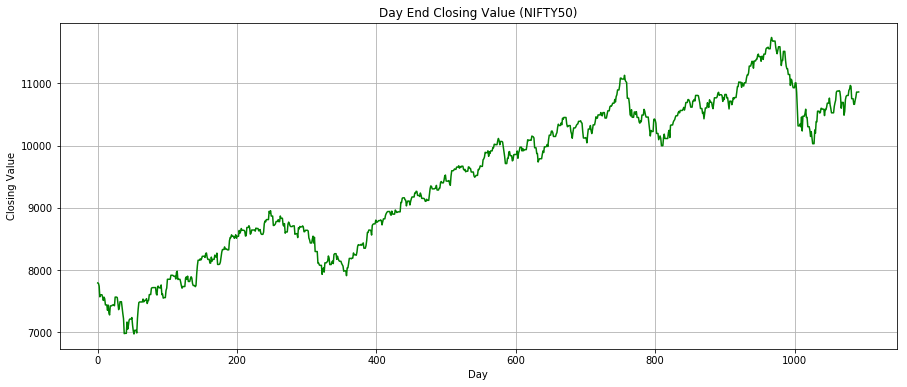

In [6]:
# Plot the data
plt.figure(figsize=(15, 6))
plt.plot(df_train['Close'],'g')
plt.title('Day End Closing Value (NIFTY50)')
plt.ylabel('Closing Value')
plt.xlabel('Day')
plt.grid(True)
plt.show()

<p> From the chart given above, it is clear that the process is not Stationary. A stationary process is one which has 
<ul>
    <li> Constant Mean across the time period </li>
    <li> Constant Variance </li>
    <li> The covariance of the m-th term and the (m + n) th term should not be a function of time. </li>
        
</ul>
</p>
<p> Clearly there is an upward trend, which means that the Mean is not constant and hence can be concluded that this is a non stationary process </p>

<p><b>Plot Moving averages - 7 days and 30 days </b></p>

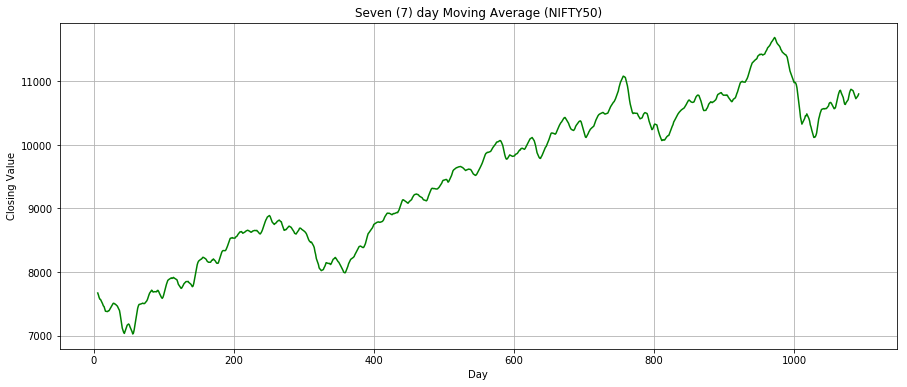

In [7]:
ma7 = df_train['Close'].rolling(7).mean()
plt.figure(figsize=(15, 6))
plt.plot(ma7,'g')
plt.title('Seven (7) day Moving Average (NIFTY50)')
plt.ylabel('Closing Value')
plt.xlabel('Day')
plt.grid(True)
plt.show()

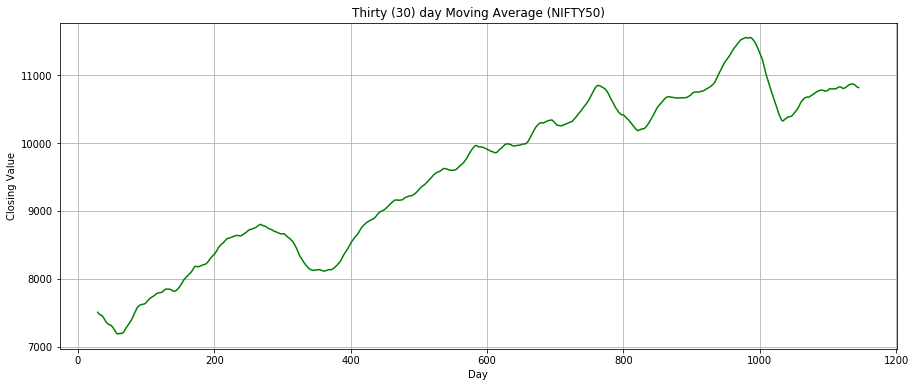

In [8]:
# Print 30 day moving averages

ma30 = model_data['Close'].rolling(30).mean()
plt.figure(figsize=(15, 6))
plt.plot(ma30,'g')
plt.title('Thirty (30) day Moving Average (NIFTY50)')
plt.ylabel('Closing Value')
plt.xlabel('Day')
plt.grid(True)
plt.show()

In [9]:
#Dickey Fuller Test to check stationarity. This prints the p value. Since p value is above 0.05, we accept the null hypothesis 
# that the process is not stationary and reject the alternate hypothesis.

print("Dickey Fuller Test :"+ str(sm.tsa.stattools.adfuller(df_train.Close)[1]))

Dickey Fuller Test :0.7436235130422437


In [10]:
# To make the process stationary, we take a difference of 1 (difference from the previous day value). And check for stationarity
df_ts = df_train['Close'] - df_train['Close'].shift(1)
sm.tsa.stattools.adfuller(df_ts[1:])[1]

0.0

<p> We can see that by taking difference, the series becomes stationary </p>

In [11]:
df_ts = df_ts[1:]

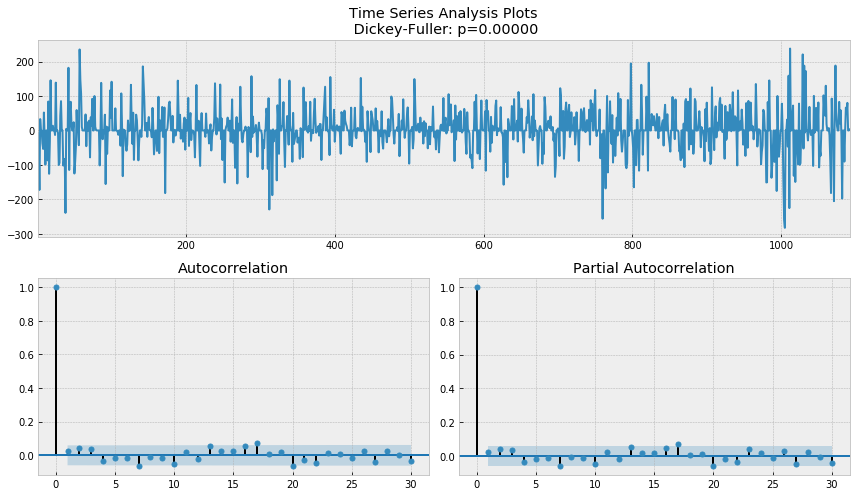

In [12]:
tsplot(df_ts,30)

<h2> Building Models </h2>
<p> Now we will start by building three models (ARIMA, Facebook Prophet and TBATS) and check which one is the most effective </p>

In [13]:
np.random.seed(100)

In [14]:
# Use Auto Arima auto_arima function from pmdarima library. It fits the model using the AIC/BIC values and searches for p,d,q and P,D,Q values
aa_model = pmd.auto_arima(df_train.Close, trace=True)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=12049.203, BIC=12079.177, Fit time=1.489 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=12045.574, BIC=12055.565, Fit time=0.041 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=12046.950, BIC=12061.937, Fit time=0.084 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=12047.017, BIC=12062.005, Fit time=0.125 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 1.748 seconds


In [15]:
# Predict in Sample to check how good the model fits on the training data
aa_pred = aa_model.predict_in_sample()
aa_train_rmse= np.sqrt(mean_squared_error(aa_pred, df_train.Close))
aa_train_mape = mean_absolute_percentage_error(df_train.Close, aa_pred)
print("Root Mean Squared Error in Sample ",aa_train_rmse)
print("Mean Absolute Percentage Error in Sample ", aa_train_mape)

Root Mean Squared Error in Sample  243.10014108262922
Mean Absolute Percentage Error in Sample  0.4992593103250338


<p> We see that we have got a 0.5% error which means almost 99.5% accuracy </p>

In [16]:
# Predict on the test data
aa_pred_test = aa_model.predict(n_periods=len(df_test))
aa_test_rmse=np.sqrt(mean_squared_error(aa_pred_test, df_test.Close))
aa_test_mape=mean_absolute_percentage_error(df_test.Close, aa_pred_test)
print("Root Mean Squared Error in Validation ",aa_test_rmse)
print("Mean Absolute Percentage Error in Validation ", aa_test_mape)

Root Mean Squared Error in Validation  161.57585091119358
Mean Absolute Percentage Error in Validation  1.1875644425859913


<p> On the test set, however, ARIMA gives an error of 1.19% which is higher than the 0.5% error on the test data. Which means that while ARIMA has fit quite well on training data, on the testing data, it has not given such a good outcome </p>

<p> Now we go for <b>Facebook's Prophet</b> which is a much more complex model.</p>

In [17]:
# Prepare Training and Testing data
Pr_train = df_train.copy()
Pr_test = df_test.copy()
Pr_train.columns = ['ds','y']

In [18]:
# Since our data is daily data, we set the daily seasonality to True and fit the model
fbm = fbp.Prophet(daily_seasonality=True)
fbm.fit(Pr_train)

In [19]:
# We check for accuracy of the model on the training dataset
future = fbm.make_future_dataframe(periods=0)
forecast = fbm.predict(future)
fbm_train_rmse = np.sqrt(mean_squared_error(forecast['yhat'].values, df_train.Close))
fbm_train_mape = mean_absolute_percentage_error(df_train.Close, forecast['yhat'].values)
print("Root Mean Squared Error in Sample ", fbm_train_rmse)
print("Mean Absolute Percentage Error in Sample ", fbm_train_mape)


Root Mean Squared Error in Sample  128.41667719353023
Mean Absolute Percentage Error in Sample  1.062783141549336


In [20]:
# The accuracy on the Training dataset is not better than ARIMA. We check for the accuracy on the Testing dataset
future_test = fbm.make_future_dataframe(periods=len(df_test))
forecast1 = fbm.predict(future_test)

fcst_test = forecast1.loc[len(Pr_train):,'yhat']
fbm_test_rmse = np.sqrt(mean_squared_error(fcst_test.values, df_test.Close))
fbm_test_mape =  mean_absolute_percentage_error(df_test.Close, fcst_test.values)
print("Root Mean Squared Error in Validation ",fbm_test_rmse)
print("Mean Absolute Percentage Error in Validation ",fbm_test_mape)


Root Mean Squared Error in Validation  489.00327682940775
Mean Absolute Percentage Error in Validation  4.1876871735188566


<p> On the training as well as the testing dataset, MAPE value of Prophet is higher than ARIMA. This is almost 95% accuracy but still ARIMA scores over Prophet </p>

In [21]:
# Now prepare and model using the TBATS algorithm
estimator = TBATS()
fitted_model = estimator.fit(df_train['Close'])

In [22]:
# Check for accuracy on training data
tbats_pred= fitted_model.y_hat
tb_train_rmse = np.sqrt(mean_squared_error(tbats_pred, df_train.Close))
tb_train_mape = mean_absolute_percentage_error(df_train.Close, tbats_pred)
print("Root Mean Squared Error in Sample ",tb_train_rmse)
print("Mean Absolute Percentage Error in Sample ", tb_train_mape)

Root Mean Squared Error in Sample  59.95422849318821
Mean Absolute Percentage Error in Sample  0.4019261880725734


In [23]:
# Now we check on the test period
tbats_fcst = fitted_model.forecast(steps=len(df_test))
tb_test_rmse = np.sqrt(mean_squared_error(tbats_fcst, df_test['Close']))
tb_test_mape =  mean_absolute_percentage_error(df_test['Close'],tbats_fcst)
print("Root Mean Squared Error in Validation ", tb_test_rmse)
print("Mean Absolute Percentage Error in Validation ", tb_test_mape)


Root Mean Squared Error in Validation  110.93039254213318
Mean Absolute Percentage Error in Validation  0.8477675153449823


<p> We see that TBATS has performed better than the two other models - both on training as well as test data </p>

In [24]:
# Now comparing the accuracies
df_values = pd.DataFrame({'MODEL' : ['AUTO ARIMA','FB PROPHET','TBATS'],
                          'TRAIN RMSE': [aa_train_rmse, fbm_train_rmse, tb_train_rmse],
                          'TEST RMSE' : [aa_test_rmse,fbm_test_rmse,tb_test_rmse],
                          'TRAIN MAPE': [aa_train_mape,fbm_train_mape, tb_train_mape],
                          'TEST MAPE' : [aa_test_mape,fbm_test_mape,tb_test_mape]
                         })
df_values

,MODEL,TRAIN RMSE,TEST RMSE,TRAIN MAPE,TEST MAPE
0,AUTO ARIMA,243.100141,161.575851,0.499259,1.187564
1,FB PROPHET,128.416677,489.003277,1.062783,4.187687
2,TBATS,59.954228,110.930393,0.401926,0.847768


<p> From the above comparison, it appears that TBATS model performs the best on all parameters in both Training as well as Test.</p>
<p> However, can we use these models as input to another model, say <b><i>XGBOOST</i></b>

In [25]:
# Create a new dataset. This dataset has predicted values from ARIMA, FB, and TBATS on the training dataset.
traindf = np.concatenate([aa_pred.reshape(-1,1), forecast['yhat'].values.reshape(-1,1), tbats_pred.reshape(-1,1) ], axis=1)

# On similar lines, create the testing dataset
testdf = np.concatenate([aa_pred_test.reshape(-1,1), fcst_test.values.reshape(-1,1), tbats_fcst.reshape(-1,1)],axis=1)

# Prepare and train the XGBOOST model
dftrain = xgb.DMatrix(data=traindf, label=df_train['Close'])
param = {'max_depth': 5, 'eta': 1, 'silent': 1, 'objective': 'reg:linear'}
num_rounds= 10
bst = xgb.train(param,dftrain,num_rounds)
bst_pred = bst.predict(dftrain)

In [26]:
# Compute accuracy on the training data.
xgb_train_rmse=np.sqrt(mean_squared_error(bst_pred, df_train.Close))
xgb_train_mape = mean_absolute_percentage_error(df_train.Close,bst_pred)
print("Root Mean Squared Error in Sample ",xgb_train_rmse)
print("Mean Absolute Percentage Error in Sample ", xgb_train_mape)

Root Mean Squared Error in Sample  41.81049401623083
Mean Absolute Percentage Error in Sample  0.33592078424962596


<p> It is apparent from the above output that XGBOOST performed really well on the training data </p>

In [27]:
# Check accuracy on the test data
dftest = xgb.DMatrix(data=testdf)
bst_fcst = bst.predict(dftest)

xgb_test_rmse=np.sqrt(mean_squared_error(bst_fcst, df_test.Close))
xgb_test_mape = mean_absolute_percentage_error(df_test.Close,bst_fcst)
print("Root Mean Squared Error in Sample ",xgb_test_rmse)
print("Mean Absolute Percentage Error in Sample ", xgb_test_mape)

Root Mean Squared Error in Sample  200.03427075298555
Mean Absolute Percentage Error in Sample  1.6229512074357446


<p> From the outcome above, XGBOOST did not do better than TBATS </p>

In [28]:
df_values1 = pd.DataFrame({'MODEL' : ['AUTO ARIMA','FB PROPHET','TBATS','XGB'],
                          'TRAIN RMSE': [aa_train_rmse, fbm_train_rmse, tb_train_rmse, xgb_train_rmse],
                          'TEST RMSE' : [aa_test_rmse,fbm_test_rmse,tb_test_rmse, xgb_test_rmse],
                          'TRAIN MAPE': [aa_train_mape,fbm_train_mape, tb_train_mape,xgb_train_mape],
                          'TEST MAPE' : [aa_test_mape,fbm_test_mape,tb_test_mape, xgb_test_mape]
                         })
df_values1

,MODEL,TRAIN RMSE,TEST RMSE,TRAIN MAPE,TEST MAPE
0,AUTO ARIMA,243.100141,161.575851,0.499259,1.187564
1,FB PROPHET,128.416677,489.003277,1.062783,4.187687
2,TBATS,59.954228,110.930393,0.401926,0.847768
3,XGB,41.810494,200.034271,0.335921,1.622951


<h2> Conclusion </h2>
<p>By just running plain Time Series models on the data, we can achieve good (even very good) accuracies. The winner of this exercise is the <b>TBATS</b> algorithm which achieved good accuracies on both training and test dataset. </p>